In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trajectory-collision-detection-avoidance-cicil/public-transport-point.csv
/kaggle/input/trajectory-collision-detection-avoidance-cicil/public-transport-line (1).csv


In [3]:
public_transport_line = pd.read_csv('/kaggle/input/trajectory-collision-detection-avoidance-cicil/public-transport-line (1).csv', delimiter='\t', on_bad_lines='skip')
public_transport_point = pd.read_csv('/kaggle/input/trajectory-collision-detection-avoidance-cicil/public-transport-point.csv', delimiter='\t', on_bad_lines='skip')

# Display the first few rows of each dataframe
print("Public Transport Line Data:")
print(public_transport_line.head())

print("\nPublic Transport Point Data:")
print(public_transport_point.head())

Public Transport Line Data:
                                                 WKT  ROUTE             REF  \
0  MULTILINESTRING ((-6.4443612 54.4164178,-6.444...  train   Belfast-Newry   
1  MULTILINESTRING ((-5.9367929 54.5942953,-5.937...  train  Belfast-Bangor   
2  MULTILINESTRING ((-5.9367929 54.5942953,-5.937...  train   Belfast-Larne   
3  MULTILINESTRING ((-6.2986063 54.8110459,-6.298...  train   Belfast-Derry   
4  MULTILINESTRING ((-6.4443612 54.4164178,-6.444...  train             NaN   

                          NAME  NAME_EN             FROM  \
0                Belfast-Newry      NaN              NaN   
1               Belfast-Bangor      NaN              NaN   
2                Belfast-Larne      NaN          Belfast   
3                Belfast-Derry      NaN              NaN   
4  Enterprise Dublin - Belfast      NaN  Dublin Connolly   

                     TO  VIA                          OPERATOR NETWORK NOTE  \
0                   NaN  NaN             Translink NI Rai

In [11]:
import pandas as pd
from shapely import wkt

public_transport_line['geometry'] = public_transport_line['WKT'].apply(wkt.loads)

def extract_coordinates(geometry):
    if geometry.geom_type == 'MultiLineString':
        return [coord for line in geometry for coord in line.coords]
    elif geometry.geom_type == 'LineString':
        return list(geometry.coords)
    else:
        return []

public_transport_line['coordinates'] = public_transport_line['geometry'].apply(extract_coordinates)

print("Public Transport Line Data with Coordinates:")
print(public_transport_line[['REF', 'coordinates']].head())

/tmp/ipykernel_33/1867392357.py:8: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return [coord for line in geometry for coord in line.coords]


Public Transport Line Data with Coordinates:
              REF                                        coordinates
0   Belfast-Newry  [(-6.4443612, 54.4164178), (-6.4447898, 54.416...
1  Belfast-Bangor  [(-5.9367929, 54.5942953), (-5.9375683, 54.594...
2   Belfast-Larne  [(-5.9367929, 54.5942953), (-5.9375683, 54.594...
3   Belfast-Derry  [(-6.2986063, 54.8110459), (-6.2987863, 54.809...
4             NaN  [(-6.4443612, 54.4164178), (-6.4447898, 54.416...


In [12]:
def calculate_features(coordinates):
    features = []
    for i in range(1, len(coordinates)):
        x1, y1 = coordinates[i-1]
        x2, y2 = coordinates[i]
        distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        direction = np.arctan2(y2 - y1, x2 - x1)
        features.append((distance, direction))
    return features

public_transport_line['features'] = public_transport_line['coordinates'].apply(calculate_features)

print("Public Transport Line Data with Features:")
print(public_transport_line[['REF', 'features']].head())

Public Transport Line Data with Features:
              REF                                           features
0   Belfast-Newry  [(0.0005368620400091156, 2.495334780918984), (...
1  Belfast-Bangor  [(0.0007806287209666991, -3.0257860890712998),...
2   Belfast-Larne  [(0.0007806287209666991, -3.0257860890712998),...
3   Belfast-Derry  [(0.0011714120752371593, -1.725068240167752), ...
4             NaN  [(0.0005368620400091156, 2.495334780918984), (...


In [14]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from shapely import wkt
from hmmlearn import hmm

def prepare_hmm_data(features_list):
    lengths = [len(features) for features in features_list]
    X = np.concatenate(features_list)
    return X, lengths

def generate_synthetic_data(num_samples, num_points):
    synthetic_features = []
    labels = []
    for _ in range(num_samples):
        coordinates = [(random.uniform(-7, -5), random.uniform(54, 55)) for _ in range(num_points)]
        features = calculate_features(coordinates)
        synthetic_features.append(features)
        labels.append('collision')
    return synthetic_features, labels

normal_features = public_transport_line['features'].tolist()
collision_features, collision_labels = generate_synthetic_data(num_samples=10, num_points=20)
normal_labels = ['normal'] * len(normal_features)

all_features = normal_features + collision_features
all_labels = normal_labels + collision_labels

X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.3, random_state=42)

X_normal_train, lengths_normal_train = prepare_hmm_data([X for X, y in zip(X_train, y_train) if y == 'normal'])
X_collision_train, lengths_collision_train = prepare_hmm_data([X for X, y in zip(X_train, y_train) if y == 'collision'])

n_components = 3
model_normal = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000)
model_normal.fit(X_normal_train, lengths_normal_train)

model_collision = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000)
model_collision.fit(X_collision_train, lengths_collision_train)

print("HMMs trained successfully!")

HMMs trained successfully!


In [16]:
import random

def predict_trajectory_type(model_normal, model_collision, features):
    score_normal = model_normal.score(features)
    score_collision = model_collision.score(features)
    return 'normal' if score_normal > score_collision else 'collision'


test_coordinates = [(random.uniform(-7, -5), random.uniform(54, 55)) for _ in range(20)]
test_features = calculate_features(test_coordinates)
trajectory_type = predict_trajectory_type(model_normal, model_collision, test_features)

print("Predicted trajectory type:", trajectory_type)

Predicted trajectory type: collision


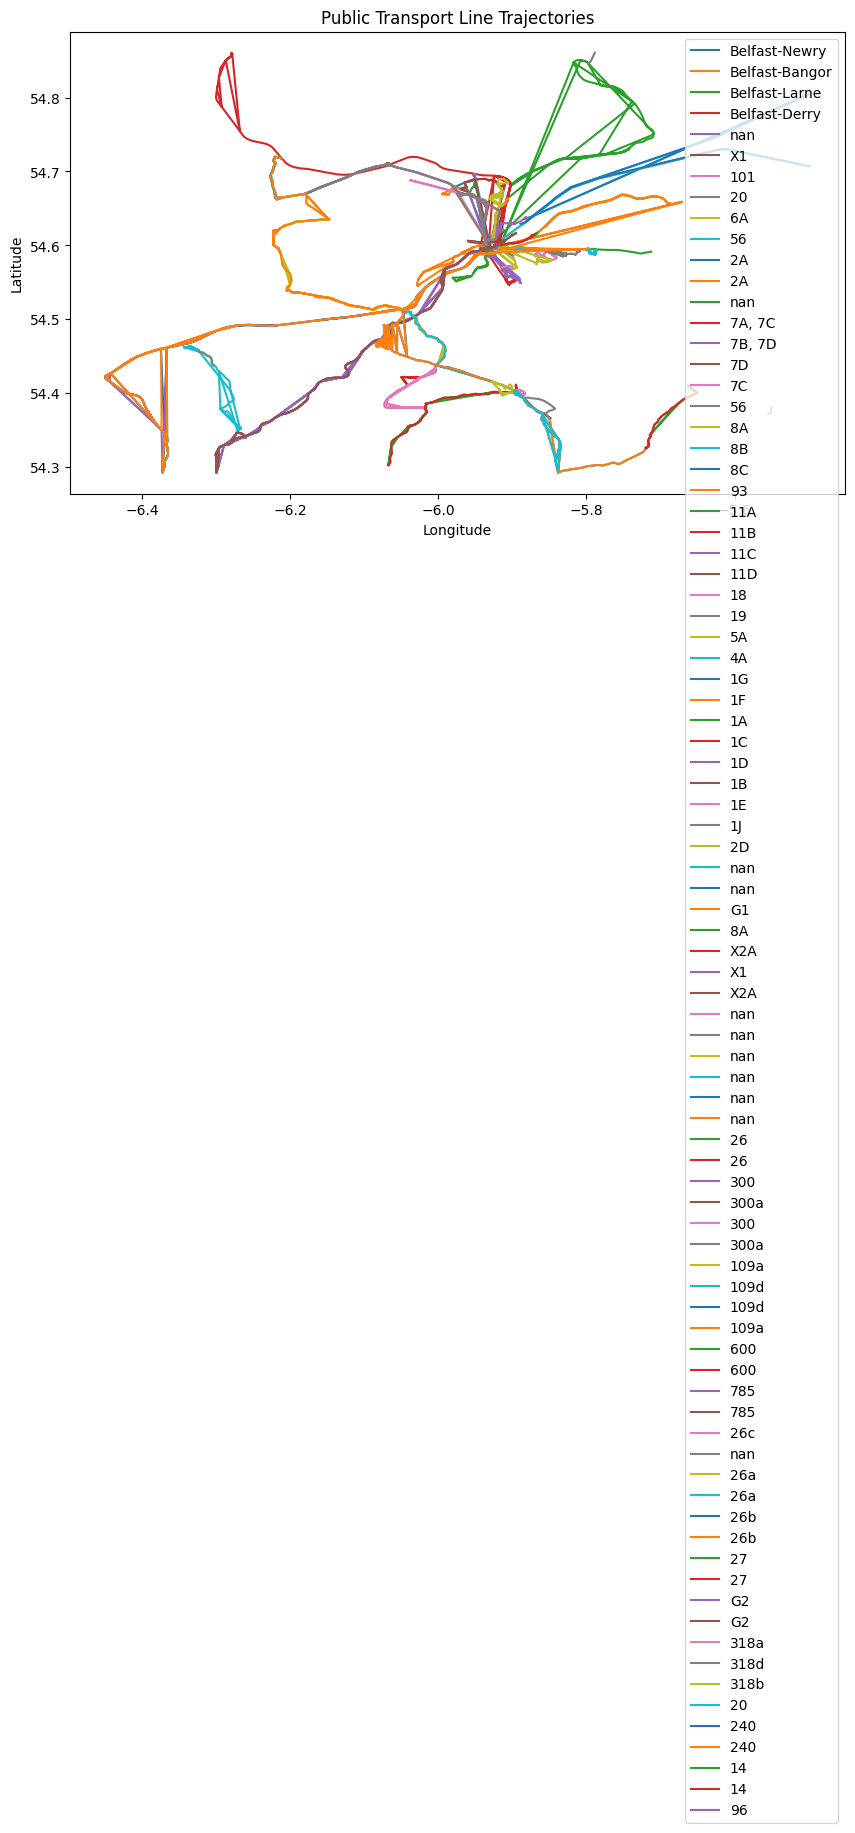

In [17]:
import matplotlib.pyplot as plt

def plot_trajectories(data, title):
    plt.figure(figsize=(10, 6))
    for index, row in data.iterrows():
        coords = row['coordinates']
        xs, ys = zip(*coords)
        plt.plot(xs, ys, label=row['REF'])
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

plot_trajectories(public_transport_line, "Public Transport Line Trajectories")

In [18]:
print("Summary Statistics of Features:")
print(public_transport_line['features'].apply(lambda x: pd.Series({
    'mean_distance': np.mean([f[0] for f in x]),
    'std_distance': np.std([f[0] for f in x]),
    'mean_direction': np.mean([f[1] for f in x]),
    'std_direction': np.std([f[1] for f in x])
})).describe())

Summary Statistics of Features:
       mean_distance  std_distance  mean_direction  std_direction
count      85.000000     85.000000       85.000000      85.000000
mean        0.002353      0.006411        0.038147       1.334947
std         0.007049      0.016118        1.067788       0.518247
min         0.000123      0.000122       -2.263324       0.208286
25%         0.000453      0.000815       -0.559811       0.905426
50%         0.000678      0.002862       -0.070964       1.406858
75%         0.000840      0.004438        0.690944       1.713272
max         0.042017      0.101020        2.839499       2.661834


In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracies = []
precisions = []
recalls = []
f1_scores = []

for train_index, test_index in kf.split(all_features):
    X_train, X_test = [all_features[i] for i in train_index], [all_features[i] for i in test_index]
    y_train, y_test = [all_labels[i] for i in train_index], [all_labels[i] for i in test_index]

    X_normal_train, lengths_normal_train = prepare_hmm_data([X for X, y in zip(X_train, y_train) if y == 'normal'])
    X_collision_train, lengths_collision_train = prepare_hmm_data([X for X, y in zip(X_train, y_train) if y == 'collision'])

    model_normal = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000)
    model_normal.fit(X_normal_train, lengths_normal_train)

    model_collision = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000)
    model_collision.fit(X_collision_train, lengths_collision_train)

    y_pred = [predict_trajectory_type(model_normal, model_collision, features) for features in X_test]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='collision', zero_division=1)
    recall = recall_score(y_test, y_pred, pos_label='collision', zero_division=1)
    f1 = f1_score(y_test, y_pred, pos_label='collision', zero_division=1)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_precision = np.mean(precisions)
std_precision = np.std(precisions)
mean_recall = np.mean(recalls)
std_recall = np.std(recalls)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f"Cross-Validation Results:")
print(f"Accuracy: {mean_accuracy:.2f} ± {std_accuracy:.2f}")
print(f"Precision: {mean_precision:.2f} ± {std_precision:.2f}")
print(f"Recall: {mean_recall:.2f} ± {std_recall:.2f}")
print(f"F1 Score: {mean_f1:.2f} ± {std_f1:.2f}")

Cross-Validation Results:
Accuracy: 0.98 ± 0.04
Precision: 0.80 ± 0.40
Recall: 1.00 ± 0.00
F1 Score: 0.80 ± 0.40


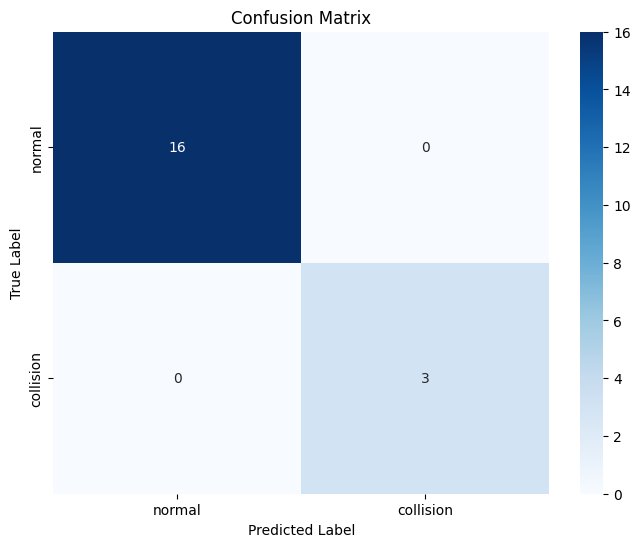

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred, labels=['normal', 'collision'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['normal', 'collision'], yticklabels=['normal', 'collision'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()